
# Классификация изображений


In [1]:
!nvidia-smi

Thu Sep 17 12:16:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Загрузка необходимых библиотек и модулей

import zipfile # Библиотека для работы с zip архивами
import os      # Библиотека для работы с фаловой системой 
import time    # Библиотека для работы со временем

from google.colab import drive # Модуль для работы с Google Disk
from PIL import Image          # Модуль Image для работы с изображениями
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

#from tensorflow.keras.applications.efficientnet import EfficientNetB6  
#import efficientnet.tfkeras as efn 
#import efficientnet.tfkeras as efn 
from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(len(os.listdir("internship_data/female")))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


In [5]:
# Подключаем гугл диск
drive.mount('/content/drive')
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/My Drive/internship_data.zip'  

Mounted at /content/drive


In [6]:
# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# Просмотр результата разархивации
print(os.listdir())

['.config', 'internship_data', 'sample_data', 'drive']


**Работаем с Tensorflow v2**

In [7]:
!pip freeze > requirements.txt

# Основные настройки

In [8]:
# Основные настройки:

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-2
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 2  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

PATH = "internship_data/" #  директория с тренировочными данными

In [9]:
# Устаналиваем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Анализ данных

Посмотрим на примеры картинок и их размеры чтобы понимать, как их лучше обработать и сжимать.

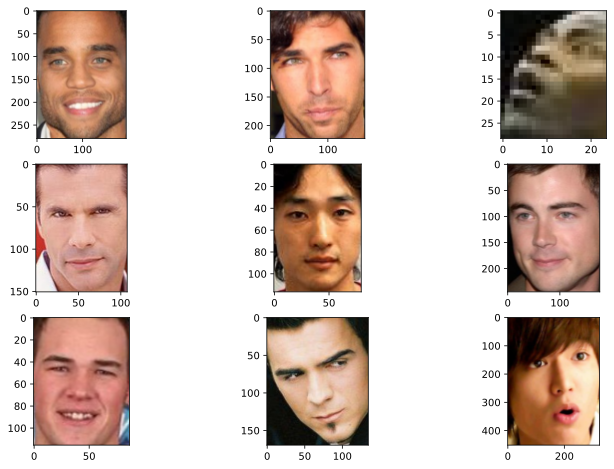

In [42]:
#фотографии мужчин
import random
nom=-1
plt.figure(figsize = (12, 8))
files_path = "internship_data/male"
for i in range(0,9):
    image_file = random.choice(os.listdir(files_path)) 
    if os.path.isfile(os.path.join(files_path,image_file)):
        image = PIL.Image.open(os.path.join(files_path,image_file))
        nom+=1
        plt.subplot(3,3, nom+1)
        plt.imshow(image)
plt.show()

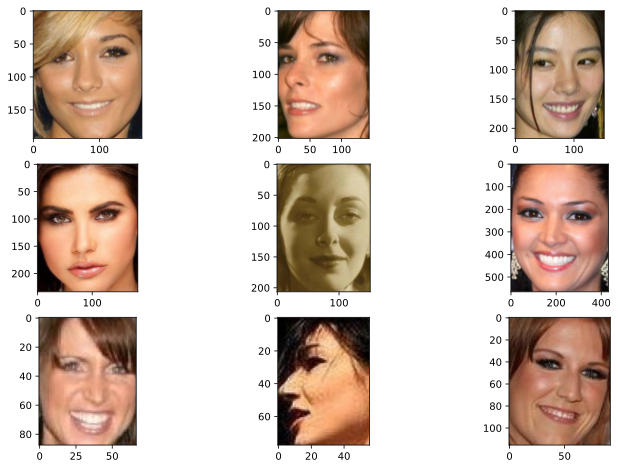

In [43]:
#фотографии женщин
import random
nom=-1
plt.figure(figsize = (12, 8))
files_path = "internship_data/female"
for i in range(0,9):
    image_file = random.choice(os.listdir(files_path)) 
    if os.path.isfile(os.path.join(files_path,image_file)):
        image = PIL.Image.open(os.path.join(files_path,image_file))
        nom+=1
        plt.subplot(3,3, nom+1)
        plt.imshow(image)
plt.show()

### Уже догадываетесь, что означают классы?

# Подготовка данных

### Генерация данных

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT, 
)

test_datagen = ImageDataGenerator(rescale=1. / 255)


In [12]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # это тренеровочный набор

test_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
   class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # валидационный набор



Found 85002 images belonging to 2 classes.
Found 15000 images belonging to 2 classes.


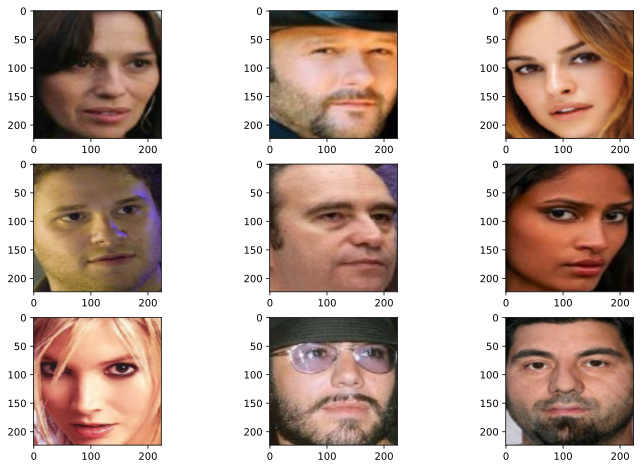

In [13]:
#посмотрим изображения, которые сформировал генератор
x, y = train_generator.next()
plt.figure(figsize = (12, 8))
for i in range(0, 9):
    image = x[i]
    plt.subplot(3,3,i+1)
    plt.imshow(image)
plt.show()

# Построение модели

### Загружаем предобученную сеть Xception:

In [14]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [15]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [16]:
# Устанавливаем новую "голову" (head)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# выходной слой
predictions = Dense(CLASS_NUM, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [18]:
# когда градиентный спуск окажется на плато, будем уменьшать шаг
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)



In [19]:
# будем сохранять лучшую модель
checkpoint = ModelCheckpoint(
    #'best_model.hdf5' , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  ,
                             filepath="best_model.hdf5",
                             mode = 'max')

# остановимся, если модель перестанет обучаться
earlystop= EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

callbacks_list = [checkpoint, reduce_lr, earlystop]


Обучаем:

In [20]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1329/1329 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9474
Epoch 00001: saving model to best_model.hdf5
1329/1329 [==============================] - 1744s 1s/step - loss: 0.1310 - accuracy: 0.9474 - val_loss: 0.0813 - val_accuracy: 0.9696
Epoch 2/10
1329/1329 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9724
Epoch 00002: saving model to best_model.hdf5
1329/1329 [==============================] - 1750s 1s/step - loss: 0.0771 - accuracy: 0.9724 - val_loss: 0.1226 - val_accuracy: 0.9586
Epoch 3/10
1329/1329 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9804
Epoch 00003: saving model to best_model.hdf5
1329/1329 [==============================] - 1747s 1s/step - loss: 0.0567 - accuracy: 0.9804 - val_loss: 0.1272 - val_accuracy: 0.9600
Epoch 4/10
1329/1329 [==============================] - ETA: 0s - loss: 0.0437 - accuracy:

In [21]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save("model_last.hdf5")
model.load_weights('best_model.hdf5')

# предсказание на тестовых данных
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))



Instructions for updating:
Please use Model.evaluate, which supports generators.
235/235 [==============================] - 66s 279ms/step - loss: 0.1241 - accuracy: 0.9811
Accuracy: 98.11%


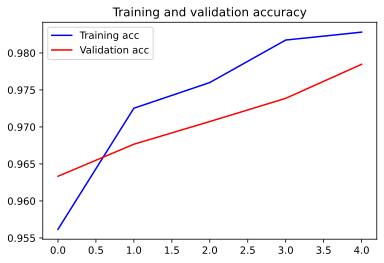

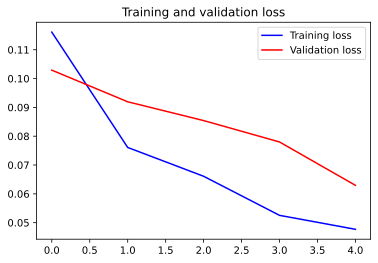

In [ ]:
# построим графики accuracy и функции потерь

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [22]:
#уменьшим скорость обучения и доучим модель:
LR = 1e-4 
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 3,
        callbacks = callbacks_list
)

Epoch 1/3
1329/1329 [==============================] - ETA: 0s - loss: 3.9328e-04 - accuracy: 0.9999
Epoch 00001: saving model to best_model.hdf5
1329/1329 [==============================] - 1741s 1s/step - loss: 3.9328e-04 - accuracy: 0.9999 - val_loss: 0.1397 - val_accuracy: 0.9807
Epoch 2/3
1329/1329 [==============================] - ETA: 0s - loss: 2.0978e-04 - accuracy: 0.9999
Epoch 00002: saving model to best_model.hdf5
1329/1329 [==============================] - 1739s 1s/step - loss: 2.0978e-04 - accuracy: 0.9999 - val_loss: 0.1566 - val_accuracy: 0.9806
Epoch 3/3
1329/1329 [==============================] - ETA: 0s - loss: 3.3301e-04 - accuracy: 0.9998
Epoch 00003: saving model to best_model.hdf5
1329/1329 [==============================] - 1740s 1s/step - loss: 3.3301e-04 - accuracy: 0.9998 - val_loss: 0.1518 - val_accuracy: 0.9813


In [23]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save("model_last.hdf5")
model.load_weights('best_model.hdf5')

# предсказание на тестовых данных
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

235/235 [==============================] - 66s 280ms/step - loss: 0.1518 - accuracy: 0.9813
Accuracy: 98.13%
